* https://pytorch.org/tutorials/beginner/data_loading_tutorial.html
* https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from tqdm.notebook import tqdm

In [3]:
# These paths are hardcoded for my system, change as needed.

image_size = 96
tokens_dataset_folder = f'b={image_size}_d=2011,2012,2013_c=all_t=2'

prefix = os.path.join(os.getcwd(), 'data', 'tokens', tokens_dataset_folder)

train_path = os.path.join(prefix, 'train', 'train.pickle')
test_path = os.path.join(prefix, 'test', 'test.pickle')
classes_path = os.path.join(prefix, 'classes.txt')

In [4]:
def encode_ohe(class_name, classes):
    one_hot = np.zeros(shape=(len(classes)), dtype=np.int8)
    class_index = classes.index(class_name)
    one_hot[class_index] = 1

    return one_hot

def decode_ohe(one_hot, classes):
    index = one_hot.argmax()
    return classes[index]

After unpickling, `train_set` and `test_set` will be lists, where each element is a dictionary that has keys `features` and `labels`. `features` will be a 1D numpy array of 1's and 0's, with size `box_size * box_size` where `box_size` is the size of the image. `label` will be a one-hot-encoded array.

In [5]:
class MathTokensDataset(Dataset):
    """
    Dataset containing math tokens extracted from the CROHME 2011, 2012, and 2013 datasets.
    """
    
    def __init__(self, pickle_file, image_size, transform=None):
        """
        Args:
            pickle_file (string): Path to dataset pickle file.
            transform (callable, optional): Optional transform to be applied
                    on a sample.
        """
        with open(pickle_file, 'rb') as f:
            self.df_data = pd.DataFrame(pickle.load(f))
        
        # Reshape features to 3D tensor.
        self.df_data['features'] = self.df_data['features'].apply(lambda vec: vec.reshape(1, image_size, image_size))
        
        # Convert one-hot labels to numbers (PyTorch expects this).
        self.df_data['label'] = self.df_data['label'].apply(lambda ohe_vec: np.argmax(ohe_vec))

        self.transform = transform
    
    def __len__(self):
        return len(self.df_data)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        sample = {
            'features': self.df_data.iloc[idx]['features'],
            'label': self.df_data.iloc[idx]['label']
        }
        
        if self.transform:
            sample = self.transform(sample)

        return sample

In [6]:
class BaselineTokenCNN(nn.Module):
    def __init__(self, num_classes):
        super(BaselineTokenCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=7)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=4, out_channels=8, kernel_size=5)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(16 * 9 * 9, 600)
        self.fc2 = nn.Linear(600, 200)
        self.fc3 = nn.Linear(200, num_classes)
        
    def forward(self, x):
        x = x.float()
        
#         print(x.shape)
        
        x = self.pool1(F.relu(self.conv1(x)))
        
#         print(x.shape)
        
        x = self.pool2(F.relu(self.conv2(x)))
        
#         print(x.shape)
        
        x = self.pool3(F.relu(self.conv3(x)))
        
#         print(x.shape)
        
        x = x.view(-1, 16 * 9 * 9)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [7]:
train_set = MathTokensDataset(train_path, image_size)
test_set = MathTokensDataset(test_path, image_size)

train_loader = DataLoader(train_set, batch_size=64, shuffle=True, num_workers=0)
test_loader = DataLoader(test_set, batch_size=8, shuffle=False, num_workers=0)

classes = np.array(open(classes_path, 'r').read().split())

In [8]:
print(f'{len(train_set)} training examples.')
print(f'{len(test_set)} test examples.')
print(f'{len(classes)} classes.')

78590 training examples.
8289 test examples.
101 classes.


In [9]:
# Set device to GPU if available.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [10]:
num_epochs = 10

net = BaselineTokenCNN(num_classes=len(classes))
net.to(device)  # Send to GPU.

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

train_loss_history = []

for epoch in tqdm(range(num_epochs)):
    
    running_loss = 0.0
    for i, data in tqdm(enumerate(train_loader), total=len(train_loader)):
        # Get the inputs and send to GPU if available.
        features = data['features'].to(device)
        labels = data['label'].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # save statistics
        
        train_loss_history.append(loss.item())
        
#         running_loss += loss.item()
#         if i % 2000 == 1999:    # print every 2000 mini-batches
#             print('[%d, %5d] loss: %.3f' %
#                   (epoch + 1, i + 1, running_loss / 2000))
#             running_loss = 0.0

print('Finished Training')



Finished Training


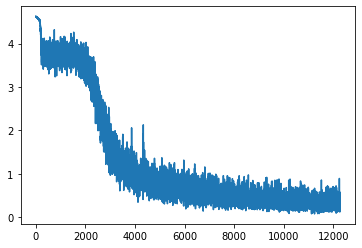

In [11]:
plt.plot(train_loss_history)

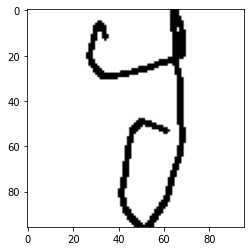

Predicted = y, Actual = y


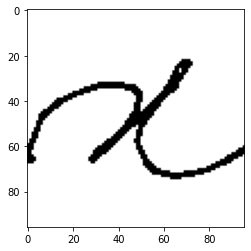

Predicted = x, Actual = x


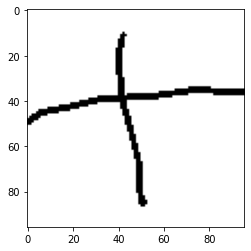

Predicted = +, Actual = +


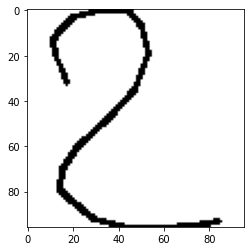

Predicted = 2, Actual = 2


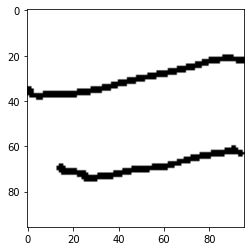

Predicted = =, Actual = =


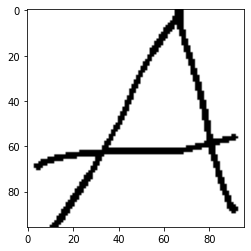

Predicted = A, Actual = A


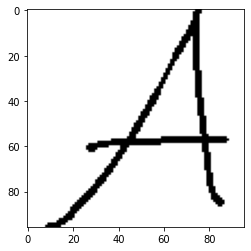

Predicted = A, Actual = A


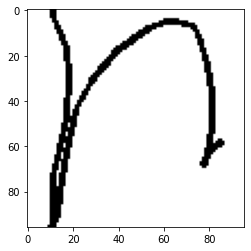

Predicted = n, Actual = n


In [12]:
test_data_iter = iter(test_loader)
data = test_data_iter.next()

test_features = data['features'].to(device)
labels = data['label'].to(device)

outputs = net(test_features)

_, predicted = torch.max(outputs.data, dim=1)

for f, l, p, in zip(test_features, labels, predicted):
    f = np.squeeze(f.cpu().numpy())
    plt.figure()
    plt.imshow(f, cmap='gray')
    plt.show()
    print(f'Predicted = {classes[p]}, Actual = {classes[l]}')

In [13]:
# Compute accuracy on the test dataset.

# TODO: Compute the per-label accuracies.
# TODO: Keep track of mispredicted classes and randomly display a few.

num_classes = len(classes)

total_counts = np.zeros(num_classes)
correct_counts = np.zeros(num_classes)

num_correct = 0
num_total_examples = 0

with torch.no_grad():
    for test_data in tqdm(test_loader):
        test_features = test_data['features'].to(device)
        labels = test_data['label'].to(device)
        
        outputs = net(test_features)
        
        _, predicted = torch.max(outputs.data, dim=1)
        
        for p, l in zip(labels, predicted):
            total_counts[l] += 1
            if p == l:
                correct_counts[p] += 1
        
        num_total_examples += labels.size(0)
        num_correct += (predicted == labels).sum().item()
        
print(f'Accuracy of the network on test set: {num_correct / num_total_examples * 100}%')


Accuracy of the network on test set: 84.54578356858488%


In [14]:
correct_counts

array([ 12., 639., 650., 394.,  31., 755.,   0.,   0., 163., 453., 485.,
       161., 106.,  59.,  59.,  51.,  47.,  63., 236.,  28.,  21.,  10.,
        10.,  16.,  11.,  14.,   3.,   9.,  19.,  17.,   5.,  11.,   0.,
        20.,   6.,  19.,   1.,  17.,   8.,  43.,  42., 100.,  11.,   0.,
         1.,   5.,   6.,   6.,   2.,  11.,  48.,   0.,  18.,  21.,  57.,
        19.,  10.,   4.,  13.,   7.,  28.,   9.,   0.,  49.,   2., 117.,
       118.,  49.,  11.,  22.,  11.,  10.,   9.,  18., 150., 102.,  34.,
       114.,  89.,  44.,   5.,   5.,  37.,   6.,  69.,   1.,  13., 130.,
         0.,  22.,   6.,   4.,   2.,  59.,   3.,   6.,   3., 413., 149.,
        56.,   0.])

In [15]:
total_counts

array([ 12., 677., 691., 426.,  75., 766.,   7.,   0., 185., 572., 549.,
       175., 121.,  76.,  86.,  66.,  61., 101., 239.,  35.,  31.,  14.,
        14.,  32.,  18.,  17.,   5.,  14.,  25.,  22.,  11.,  14.,   1.,
        23.,   6.,  36.,   3.,  42.,   9.,  52.,  48., 102.,  11.,   0.,
         1.,   7.,   6.,   7.,   2.,  21.,  57.,   0.,  18.,  30.,  63.,
        24.,  11.,   6.,  17.,   7.,  33.,  14.,   0.,  49.,   4., 124.,
       131.,  52.,  19.,  32.,  33.,  10.,  14.,  21., 218., 137.,  55.,
       146.,  95.,  60.,   8.,   9.,  39.,   9.,  79.,   4.,  34., 157.,
         0.,  43.,  15.,   9.,  24.,  76.,   8.,  23.,   7., 458., 210.,
        83.,   0.])

In [16]:
correct_counts / total_counts

c:\users\jamin chen\development\10617_project\venv\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


array([1.        , 0.94387001, 0.9406657 , 0.92488263, 0.41333333,
       0.98563969, 0.        ,        nan, 0.88108108, 0.79195804,
       0.88342441, 0.92      , 0.87603306, 0.77631579, 0.68604651,
       0.77272727, 0.7704918 , 0.62376238, 0.9874477 , 0.8       ,
       0.67741935, 0.71428571, 0.71428571, 0.5       , 0.61111111,
       0.82352941, 0.6       , 0.64285714, 0.76      , 0.77272727,
       0.45454545, 0.78571429, 0.        , 0.86956522, 1.        ,
       0.52777778, 0.33333333, 0.4047619 , 0.88888889, 0.82692308,
       0.875     , 0.98039216, 1.        ,        nan, 1.        ,
       0.71428571, 1.        , 0.85714286, 1.        , 0.52380952,
       0.84210526,        nan, 1.        , 0.7       , 0.9047619 ,
       0.79166667, 0.90909091, 0.66666667, 0.76470588, 1.        ,
       0.84848485, 0.64285714,        nan, 1.        , 0.5       ,
       0.94354839, 0.90076336, 0.94230769, 0.57894737, 0.6875    ,
       0.33333333, 1.        , 0.64285714, 0.85714286, 0.68807

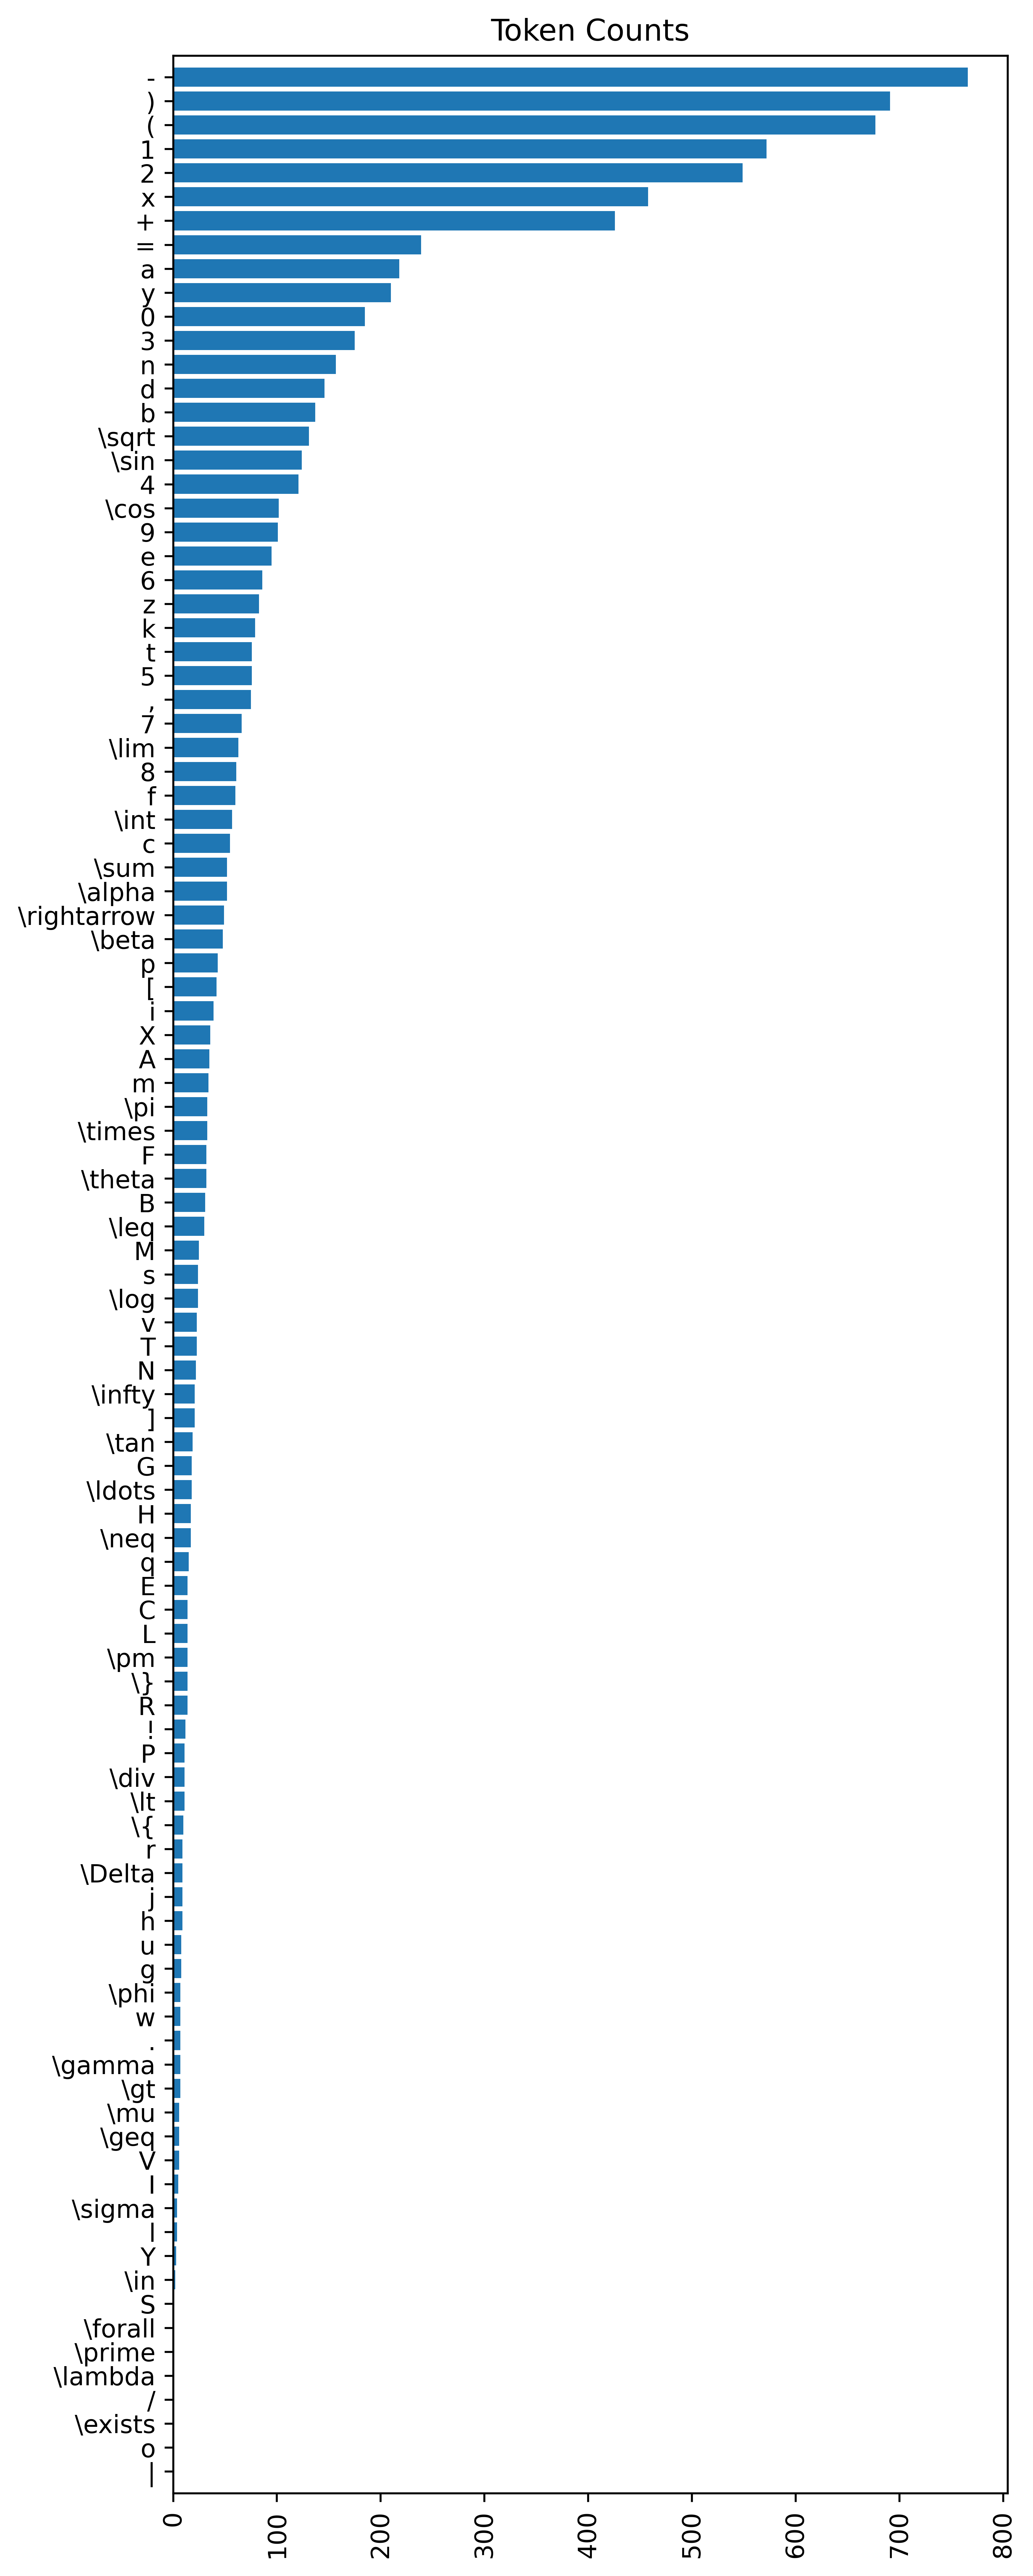

In [40]:
total_counts_idx = np.argsort(total_counts)
total_counts_idx = total_counts_idx.astype(int)

plt.figure(figsize=(6,18), dpi=600)
plt.barh(classes[total_counts_idx], total_counts[total_counts_idx])
plt.title('Token Counts')
plt.xticks(rotation=90)
plt.margins(y=0.005)
plt.show()

c:\users\jamin chen\development\10617_project\venv\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


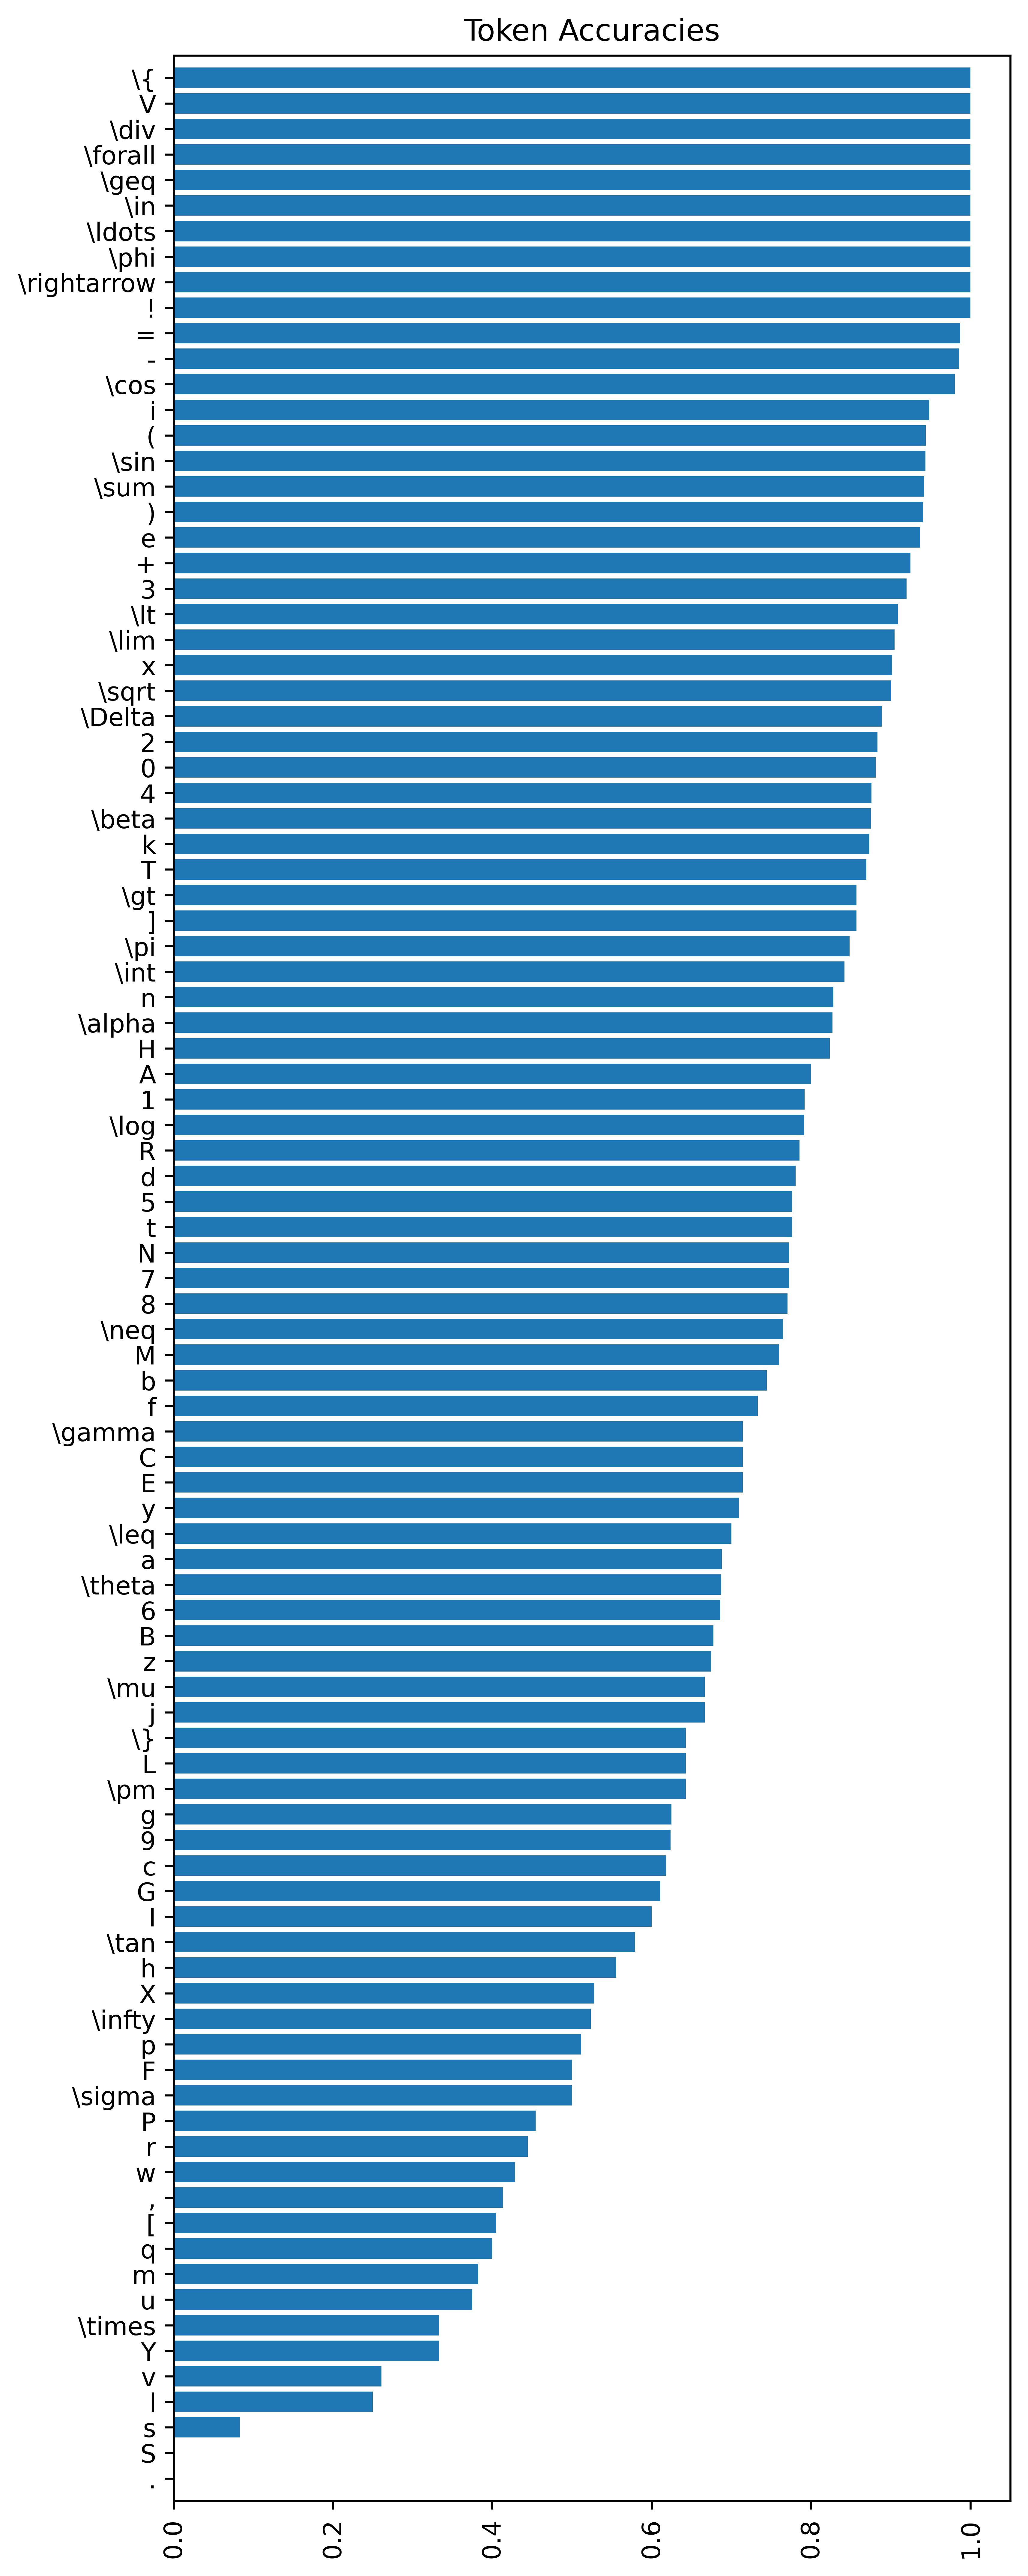

In [41]:
total_acc = correct_counts / total_counts

total_acc_idx = np.argsort(total_acc)
# total_acc_idx = total_acc_idx.astype(int)

plt.figure(figsize=(6,18), dpi=600)
plt.barh(classes[total_acc_idx], total_acc[total_acc_idx])
plt.title('Token Accuracies')
plt.xticks(rotation=90)
plt.margins(y=0.005)
plt.show()